# Inferring graphs from survey data

In this notebook we discuss a simple method for representing survey data using graphs. This is where the [_surveygraph_](https://github.com/surveygraph) package comes in.

We assume users have a basic knowledge of R and graphs. In particular, we will be working with the _igraph_ package in order to visualise and analyse the graph data produced by _surveygraph_. An introduction to R and _igraph_ can be found on the _surveygraph_ [Github page](https://github.com/surveygraph/surveygraph-tutorials).

## Similarity measure

The main idea in this method is to compare the responses of pairs of individuals, and come up with a measure of their similarity. We define similarity as a number between 0 and 1 measuring the distance between individual responses.

### Respondent similarity



As a very simple example, let's consider the following survey where individuals respond to a single statement on a five-point Likert scale. Suppose the statement is _I enjoy programming in the R language_, with 1 being strongly disagree, and 5 being strongly agree. We refer to this question as _item one_ in this survey.

|id|item one|
|:-|:-|
|_Sam_|4|
|_Ana_|5|
|_Caoimhe_|4|
|_Paul_|2|
|_Megan_|1|
|_David_|3|

A simple measure of similarity uses the normalised difference between the users' responses. On an L-point Likert scale, these differences take the values 0, 1, 2, ..., L - 1. To force these differences within the range 0 to 1, we divide, or normalise the difference by L - 1. If we were to leave it at that, a normalised difference of 0 mean individuals respond identically, and a difference of 1 means they are as far apart as possible. Since we want a positive measure of similarity, we subtract the normalised difference from 1.

Let's apply this to the above survey. Consider Sam and Ana, whose responses are 4 and 5, respectively. The difference between their responses is 1. The normalised difference is 0.25, meaning their similarity is 0.75.

The idea simply is to treat this matrix as a complete weighted graph. The weighted neighbour list corresponding to the above table is

<div class='sidenote-cell'>
We can formalise this measure as follows. For a given item on an $L$-point Likert scale, if $r_u$ and $r_v$ are the responses of individuals $u$ and $v$, respectively, the similarity $s$ between $u$ and $v$ is given by 
\begin{equation}
    s = 1 - \dfrac{|r_u - r_v|}{L - 1}.
\end{equation}
</div>

By comparing each pair of respondents in the above example, we produce the symmetric table of similarities below. We have referred to this as the agent, or respondent projection of the survey.

||_Sam_|_Ana_|_Caoimhe_|_Paul_|_Megan_|_David_|
|:-|:-|:-|:-|:-|:-|:-|
|_Sam_|-| 0.75| 1.0| 0.5| 0.25| 0.75|
|_Ana_| 0.75|-| 0.75| 0.25| 0.0| 0.5|
|_Caoimhe_| 1.0| 0.75|-| 0.5| 0.25| 0.75|
|_Paul_| 0.5| 0.25| 0.5|-| 0.75| 0.5|
|_Megan_|0.25|0.0|0.25|0.75|-|0.5|
|_David_|0.75|0.5|0.75|0.5|0.5|-|

In [59]:
el1 <- data.frame(
    u = c('Sam','Sam','Sam','Sam','Sam','Ana','Ana','Ana','Ana','Caoimhe','Caoimhe','Caoimhe','Paul','Paul','Megan'),
    v = c('Ana','Caoimhe','Paul','Megan','David','Caoimhe','Paul','Megan','David','Paul','Megan','David','Megan','David','David'),
    weight = c(0.75,1,0.5,0.25,0.75,0.75,0.25,0,0.5,0.5,0.25,0.75,0.75,0.5,0.5)
)

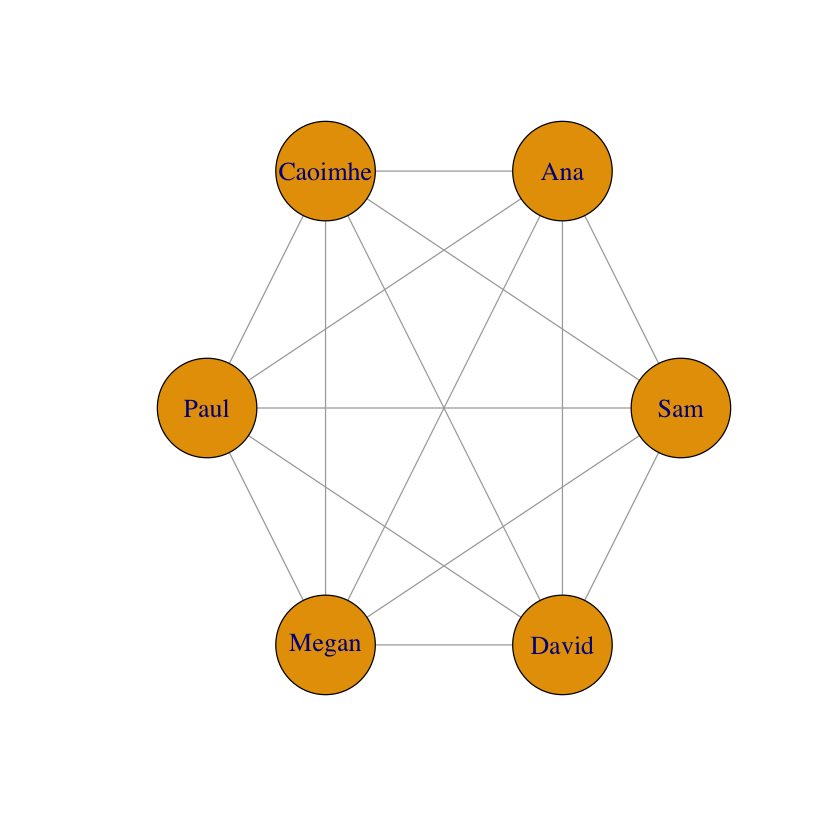

In [87]:
library('igraph')

g <- graph_from_data_frame(el1, directed=FALSE)

plot(
    g, 
    layout=layout.circle,
    vertex.size = 42,
    vertex.label.cex = 1.3,
)

Trivially, we can express this as complete weighted graph, in which nodes are survey respondents, and edge weights are the similarity scores of adjacent nodes. Rewriting the above table in neighbour list format gives

|||||||
|:-|:-|:-|:-|:-|:-|
|_Sam_|_Ana_ 0.75|_Caoimhe_ 1.0|_Paul_ 0.5|_Megan_ 0.25|_David_ 0.75|
|_Ana_|_Sam_ 0.75|_Caoimhe_ 0.75|_Paul_ 0.25|_Megan_ 0.0|_David_ 0.5|
|_Caoimhe_|_Sam_ 1.0|_Ana_ 0.75|_Paul_ 0.5|_Megan_ 0.25|_David_ 0.75|
|_Paul_|_Sam_ 0.5|_Ana_ 0.25|_Caoimhe_ 0.5|_Megan_ 0.75|_David_ 0.5|
|_Megan_|_Sam_ 0.5|_Ana_ 0.25|_Caoimhe_ 0.5|_Paul_ 0.75|_David_ 0.5|
|_David_|_Sam_ 0.5|_Ana_ 0.25|_Caoimhe_ 0.5|_Paul_ 0.75|_Megan_ 0.5|

When we take into account multiple survey items, we simply compute the average of the similarity scores for each item. The resulting average similarity is therefore between 0 and 1 too.

### Item similarity

Almost identical to the above, we can compare the responses of a single individual across multiple items to compute a similarity score between items. Here, it is important to normalise _before_ computing the differences between responses, since a response of 3 on a 5-point Likert scale is different to 3 on a 5-point Likert scale.

|u|item one|item two|item three|
|:-|:-|:-|:-|
|_Ana_|2|5|2|

For example, assume items 1 and 2 correspond to a 5-point Likert scale, and item 3 a 3-point Likert scale. Normalising each response according to the formulat $(r_i - 1) / (L_i - 1)$ we get

|u|item one|item two|item three|
|:-|:-|:-|:-|
|_Ana_|0.25|1|0.5|

We infer the range of the Likert scale by examining the entire survey, assuming that at least one individual for each item has provided the maximum and minimum responses.

Now we can compute the similarity of each pair of items as before, producing the table

||item one|item two|item three|
|:-|:-|:-|:-|
|item one|-|0.75|0.25|
|item two|0.75|-|0.5|
|item three|0.25|0.5|-|

For completeness, the same data in a complete weighted neighbour list format is 

||||
|:-|:-|:-|
|_item one_|_item two_ 0.75|_item three_ 0.25|
|_item two_|_item one_ 0.75|_item three_ 0.5|
|_item three_|_item one_ 0.25|_item two_ 0.5|


In [88]:
el2 <- data.frame(
    u = c('item1', 'item1', 'item2'),
    v = c('item2', 'item3', 'item3'),
    w = c(0.75, 0.25, 0.5)
)

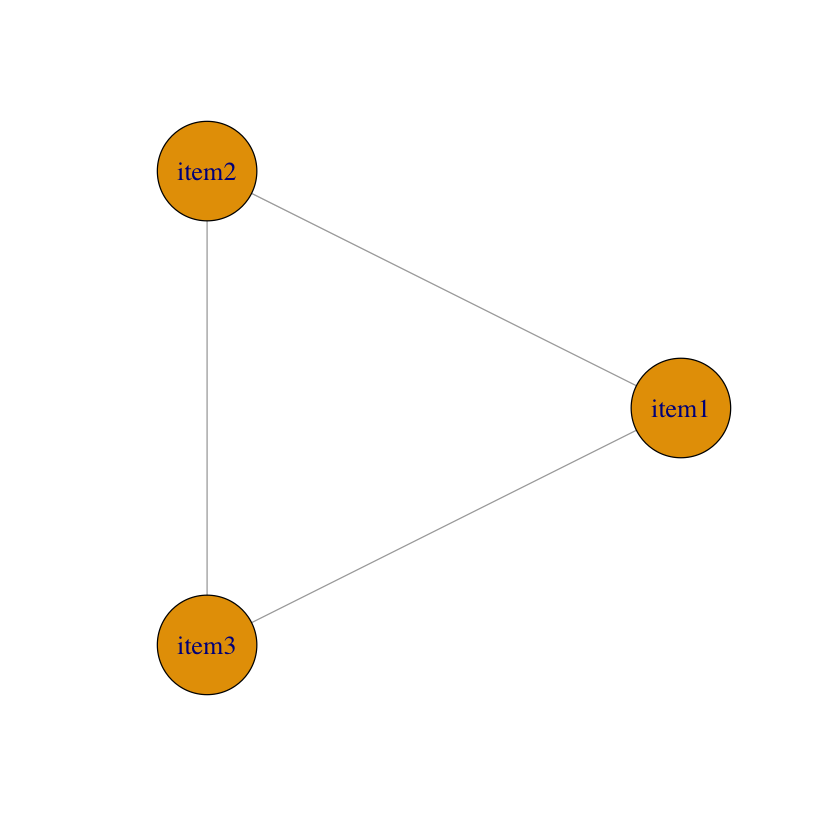

In [89]:
g <- graph_from_data_frame(el2, directed=FALSE)

plot(
    g, 
    layout=layout.circle,
    vertex.size = 42,
    vertex.label.cex = 1.3,
)

<div class='sidenote-cell'>
We can formalise this measure as follows. For a given individual responding to an $L_i$ and $L_j$ point Likert scales, if $r_i$ and $r_j$ are the responses to items $i$ and $j$, respectively, the similarity $s$ between items $i$ and $j$ is given by 
\begin{equation}
    s = 1 - \left|\dfrac{r_i - 1}{L_i - 1} - \dfrac{r_j - 1}{L_j - 1}\right|.
\end{equation}
This may appear different to the similarity measure for respondents
<!-- \begin -->
\begin{equation}
\begin{split}
s & = 1 - \left|\dfrac{r_u - 1}{L_u - 1} - \dfrac{r_v - 1}{L_v - 1}\right| \\
  & = 1 - \dfrac{|r_u - r_v|}{L - 1}
\end{split}
\end{equation}
using the fact that $L = L_u = L_v$ following our notation in the previous section, as we're comparing the responses of individuals for a single item, meaning the Likert scale is identical across responses.
<br><br>
In practice, when we read in a survey with the _surveygraph_ package, one of the pre-processing steps is to normalise all responses in this way prior to comparing responses across individuals or items.
</div>

### Uncertainty

The original paper did not address uncertainty around the edges, nor have any works since. A simple technique is currently in beta in the _surveygraph_ package.

## Thresholding similarity values

The idea is to use this to discover clusters of individuals with similar attitudes, for example if respondents are polarised in some way.

## Model survey data

In [34]:
# define custom CSS styles
customcss <- "
<style>
  .sidenote-cell {
    overflow-x: hidden;
    background-color: lightblue;
    padding: 10px;
    width: calc(100% + 40px);
    margin-left: -10px;
    box-sizing: border-box;
  }
</style>
"

# display the custom CSS styles
IRdisplay::display_html(customcss)